# Aula 17 - Meta-Learning

- Boosting, Bagging and Stacking

#### Imports das bibliotecas

In [1]:
!pip install pydataset

import numpy as np
import pandas as pd
import seaborn as sns
from pydataset import data
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize, StandardScaler

%matplotlib inline

#### Carregando os dados

In [2]:
dataset = data('Housing')

#### Descrição

O conjunto contêm 546 observações sobre os preços de venda de casas vendidas em julho, agosto e setembro de 1987 na cidade de Windsor, Canadá.

- **price**: preço de venda de uma casa
- **lotsize**: tamanho do lote em pés quadrados
- **bedrooms**: número de quartos
- **bathrms**: número de banheiros completos
- **stories**: número de andares (excluindo porão)
- **driveway**: garagem
- **recroom**: sala de recreação
- **fullbase**: porão completo
- **gashw**: gás para aquecimento de água quente
- **airco**: ar condicionado central
- **garagepl**: número de vagas na garagem 
- **prefarea**: se é localizado no bairro preferido da cidade

#### Exploração dos dados

In [3]:
dataset.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
1,42000.0,5850,3,1,2,yes,no,yes,no,no,1,no
2,38500.0,4000,2,1,1,yes,no,no,no,no,0,no
3,49500.0,3060,3,1,1,yes,no,no,no,no,0,no
4,60500.0,6650,3,1,2,yes,yes,no,no,no,0,no
5,61000.0,6360,2,1,1,yes,no,no,no,no,0,no


In [4]:
print('Linhas: {} e colunas: {}'.format(dataset.shape[0], dataset.shape[1]))

Linhas: 546 e colunas: 12


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546 entries, 1 to 546
Data columns (total 12 columns):
price       546 non-null float64
lotsize     546 non-null int64
bedrooms    546 non-null int64
bathrms     546 non-null int64
stories     546 non-null int64
driveway    546 non-null object
recroom     546 non-null object
fullbase    546 non-null object
gashw       546 non-null object
airco       546 non-null object
garagepl    546 non-null int64
prefarea    546 non-null object
dtypes: float64(1), int64(5), object(6)
memory usage: 55.5+ KB


In [6]:
print('Colunas presentes: {}'.format(dataset.columns))

Colunas presentes: Index(['price', 'lotsize', 'bedrooms', 'bathrms', 'stories', 'driveway',
       'recroom', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea'],
      dtype='object')


#### Analisando a faixa de preços das casas

In [7]:
for i, j in enumerate(np.unique(pd.qcut(dataset['price'], 3))):
    print(i, j)

0 (24999.999, 53000.0]
1 (53000.0, 74500.0]
2 (74500.0, 190000.0]


In [8]:
print('Preço máximo: ${}'.format(dataset['price'].max()))
print('Preço mínimo: ${}'.format(dataset['price'].min()))

Preço máximo: $190000.0
Preço mínimo: $25000.0


#### Estatísticas

In [9]:
dataset.describe()

,price,lotsize,bedrooms,bathrms,stories,garagepl
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,68121.597070,5150.265568,2.965201,1.285714,1.807692,0.692308
std,26702.670926,2168.158725,0.737388,0.502158,0.868203,0.861307
min,25000.000000,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,49125.000000,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,62000.000000,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,82000.000000,6360.000000,3.000000,2.000000,2.000000,1.000000
max,190000.000000,16200.000000,6.000000,4.000000,4.000000,3.000000


#### Cria um dicionário para rotular as variáveis binárias e normaliza a coluna price

In [10]:
d = dict(zip(['no', 'yes'], range(0,2)))

for i in zip(dataset.dtypes.index, dataset.dtypes):
    if str(i[1]) == 'object':
        dataset[i[0]] = dataset[i[0]].map(d)
        
dataset['price'] = pd.qcut(dataset['price'], 3, labels=['0', '1', '2']).cat.codes

#### Correlação

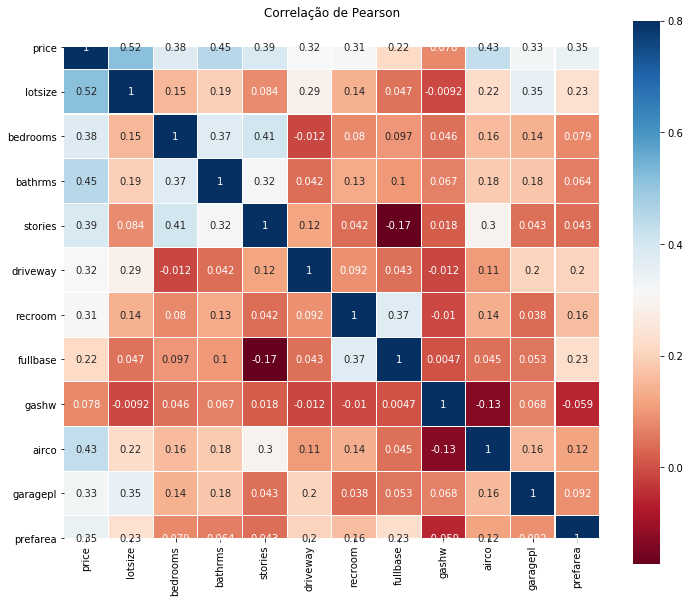

In [11]:
colormap = plt.cm.RdBu
plt.figure(figsize=(12, 10))
plt.title('Correlação de Pearson', y=1.05, size=12)
sns.heatmap(dataset.astype(float).corr(),linewidths=0.1, vmax=0.8, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### Separação dos dados

In [12]:
y = dataset['price']
X = dataset.drop(['price'], axis=1)

#### Bagging

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

In [14]:
seed = 1075
np.random.seed(seed)

#### Criando os classificadores

In [15]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()

In [16]:
clf_array = [rf, et, knn, svc, rg]

#### Comparação entre o score de cada modelo x BaggingClassifier

In [17]:
for clf in clf_array:
    scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
    
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10, n_jobs=-1)
    
    print('Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]'.format(clf.__class__.__name__, 
                                                              scores.mean(), scores.std()))
    print('Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n'.format(clf.__class__.__name__, 
                                                                        bagging_scores.mean(), 
                                                                        bagging_scores.std()))

Mean of: 0.650, std: (+/-) 0.097 [RandomForestClassifier]
Mean of: 0.654, std: (+/-) 0.077 [Bagging RandomForestClassifier]

Mean of: 0.647, std: (+/-) 0.083 [ExtraTreesClassifier]
Mean of: 0.652, std: (+/-) 0.086 [Bagging ExtraTreesClassifier]

Mean of: 0.500, std: (+/-) 0.086 [KNeighborsClassifier]
Mean of: 0.535, std: (+/-) 0.111 [Bagging KNeighborsClassifier]

Mean of: 0.561, std: (+/-) 0.079 [SVC]
Mean of: 0.575, std: (+/-) 0.078 [Bagging SVC]

Mean of: 0.639, std: (+/-) 0.050 [RidgeClassifier]
Mean of: 0.597, std: (+/-) 0.045 [Bagging RidgeClassifier]



#### Escolha por votação 

In [18]:
from sklearn.ensemble import VotingClassifier

In [19]:
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), 
                                    ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')

In [20]:
for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 
                                                     'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print('Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]'.format(scores.mean(), scores.std(), label))

Mean: 0.654, std: (+/-) 0.095 [Random Forest]
Mean: 0.641, std: (+/-) 0.077 [Extra Trees]
Mean: 0.500, std: (+/-) 0.086 [KNeighbors]
Mean: 0.561, std: (+/-) 0.079 [SVC]
Mean: 0.639, std: (+/-) 0.050 [Ridge Classifier]
Mean: 0.630, std: (+/-) 0.086 [Ensemble]


#### Escolha por votação para bagging

In [21]:
ebclf_array = []

for clf in clf_array:
    ebclf_array.append(BaggingClassifier(clf, max_samples=0.2, max_features=10, random_state=seed))

v_eclf = VotingClassifier(estimators=zip(['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                                          'Bagging SVC', 'Bagging Ridge Classifier', 'Bagging Ensemble'],
                                         ebclf_array), voting='hard')

ebclf_array.append(v_eclf)

In [22]:
for clf, label in zip(ebclf_array, ['Bagging Random Forest', 'Bagging Extra Trees', 'Bagging KNeighbors',
                              'Bagging SVC', 'BaggingRidge Classifier', 'Bagging Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print('Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]'.format(scores.mean(), scores.std(), label))

Mean: 0.652, std: (+/-) 0.091 [Bagging Random Forest]
Mean: 0.646, std: (+/-) 0.078 [Bagging Extra Trees]
Mean: 0.564, std: (+/-) 0.118 [Bagging KNeighbors]
Mean: 0.603, std: (+/-) 0.093 [Bagging SVC]
Mean: 0.610, std: (+/-) 0.053 [BaggingRidge Classifier]
Mean: nan, std: (+/-) nan [Bagging Ensemble]


/home/liliane-hop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'zip' has no len()

  FitFailedWarning)


#### Boosting

In [23]:
from mlxtend.classifier import EnsembleVoteClassifier
import warnings
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

/home/liliane-hop/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


#### Cria os modelos

In [24]:
ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
xgb_boost = XGBClassifier()

eclf = EnsembleVoteClassifier(clfs=[ada_boost, grad_boost, xgb_boost], voting='hard')
labels = ['Ada Boost', 'Grad Boost', 'XG Boost', 'Ensemble']

In [25]:
for clf, label in zip([ada_boost, grad_boost, xgb_boost, eclf], labels):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Mean: {0:.3f}, std: (+/-) {1:.3f} [{2}]".format(scores.mean(), scores.std(), label))

Mean: 0.641, std: (+/-) 0.082 [Ada Boost]
Mean: 0.630, std: (+/-) 0.103 [Grad Boost]
Mean: 0.635, std: (+/-) 0.099 [XG Boost]
Mean: 0.626, std: (+/-) 0.091 [Ensemble]


#### Stacking

In [26]:
from mlens.ensemble import SuperLearner
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

[MLENS] backend: threading


In [27]:
lr = LogisticRegression()
seed = 1075

ensemble = SuperLearner(scorer = accuracy_score, random_state=seed, folds=10, verbose = 2)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

#### Construindo a primeira camada

In [29]:
ensemble.add([rf, et, knn, rg])

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4128, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...98131e0>)],
   n_jobs=-1, name='group-0', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=1075, sample_size=20,
       scorer=<function accuracy_score at 0x7f6fc98131e0>, shuffle=False,
       verbose=2)

#### Anexando ao meta-estimador final

In [30]:
ensemble.add_meta(lr)

SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=4128, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...98131e0>)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=1075, sample_size=20,
       scorer=<function accuracy_score at 0x7f6fc98131e0>, shuffle=False,
       verbose=2)

#### Predição

In [31]:
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

print('Fit data:\n%r' % ensemble.data)
print('Accuracy score: {:.3f}'.format(accuracy_score(y_pred, y_test)))


Fitting 2 layers
Processing layer-1             done | 00:00:06
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:06

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00
Fit data:
                                   score-m  score-s  ft-m  ft-s  pt-m  pt-s
layer-1  extratreesclassifier         0.66     0.09  2.23  0.21  0.06  0.04
layer-1  kneighborsclassifier         0.51     0.07  0.01  0.01  0.09  0.06
layer-1  randomforestclassifier       0.67     0.08  2.10  0.24  0.06  0.06
layer-1  ridgeclassifier              0.65     0.08  0.02  0.01  0.00  0.00

Accuracy score: 0.713


#### Combinando os modelos

In [32]:
from itertools import combinations

In [33]:
names = ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier']

def zip_stacked_classifiers(*args):
    to_zip = []
    for arg in args:
        combined_items = sum([map(list, combinations(arg, i)) for i in range(len(arg) + 1)], [])
        combined_items = filter(lambda x: len(x) > 0, combined_items)
        to_zip.append(combined_items)
    
    return zip(to_zip[0], to_zip[1])

In [34]:
stacked_clf_list = zip_stacked_classifiers(clf_array, names)
best_combination = [0.00, '']

for clf in stacked_clf_list:
    
    ensemble = SuperLearner(scorer = accuracy_score, 
                            random_state = seed, 
                            folds = 10)
    ensemble.add(clf[0])
    ensemble.add_meta(lr)
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_test)
    accuracy = accuracy_score(preds, y_test)
    
    if accuracy > best_combination[0]:
        best_combination[0] = accuracy
        best_combination[1] = clf[1]
    
    print('Accuracy score: {:.3f} {}'.format(accuracy, clf[1]))

print('\nBest stacking model is {} with accuracy of: {:.3f}'.format(best_combination[1], best_combination[0]))

TypeError: can only concatenate list (not "map") to list